# **Benign vs. Malignant Skin Lesion Classifier**

# Setting Up Environment

In [1]:
# Import and configure warnings to ignore minor warnings
from warnings import filterwarnings

# Visualization libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import numerical operations and array handling library
import numpy as np

# Import core PyTorch libraries for neural network construction
import torch
import torch.nn as nn  # Neural network layers and functions
import torch.optim as optim # Optimization algorithms

# Import sklearn's confusion matrix for model evaluation
from sklearn.metrics import confusion_matrix

# Import modules for analysing results
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# Import torchvision for image-based model utilities
from torchvision import models, datasets, transforms # Pre-built models, data handling, and image transformations

# Data loader utilities for batching, shuffling, and splitting data
from torch.utils.data import DataLoader, random_split

# Utilities for mixed precision training to enhance performance
from torch.cuda.amp import autocast, GradScaler

# Learning rate scheduler to improve training efficiency
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Import metric calculation tools specifically for classification
from torchmetrics.classification import BinaryAccuracy

# Import tqdm for progress bar visualisation
# The 'autonotebook' submodule automatically chooses the appropriate interface (text or graphical).
from tqdm.autonotebook import tqdm

# Image file processing
import PIL
from PIL import Image

# Allows reading/writing of files using operating system dependent manouvers
import os
import copy

# Set the font family to Avenir globally
plt.rcParams['font.family'] = 'Avenir'

# Ignore warnings that do not signal breakdown
filterwarnings('ignore')

In [2]:
# Sets the device for computation to 'cuda' (GPU) if available, otherwise goes back to 'cpu' (Central Processing Unit). 
# This enables optimal use of hardware by leveraging GPU acceleration when possible.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Cleaning and Analysing DataSet

In [3]:
# Defines image target size after the following transformations - referred to in the resizing line
ImageDimensions = 170

# Training transformer - These random transformations help in augmenting the data by providing varied orientations and perspectives of the 
# same image,thus helping the model generalise better during training by learning to recognise patterns under various transformations - especially useful for DermaTrack
transformer = transforms.Compose([
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True), # Resises to ImageDimensions dimensions with antialias to keep image quality high
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),#Crops from the centre of the image to keep the lesion in the image
    # Rotate and Flip for better training
    transforms.RandomRotation(degrees = 20),# Random rotation +/-20 degrees
    transforms.RandomHorizontalFlip(p = 0.3), # Random horizontal flip occurs 30% of the time
    transforms.RandomVerticalFlip(p = 0.3), # Random vertical flip occurs 30% of the time
    # Convert for model 
    transforms.ToTensor(), # Converts all images to tensors, which is a suitable input for the model
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Normalises the tensors using standard mean and std
])

# Test/Validation transformer - does the same as above without the random flips/rotations
# Randomness is exluded to ensure consistency in evaluation so images are simply formatted
valTransformer = transforms.Compose([
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True),
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [4]:
# Defining the path to the Kaggle input
DATA_PATH = '/kaggle/input'

# Defining a function to get the distribution of data classes
def get_data_distribution(data):
    # Sets the path to the datset
    data_path = data
    # Initialises an empty dictionary to store the count of images for each class
    class_counts = {}

    # Iterates through each class label in the dataset directory
    for class_label in os.listdir(data_path):
        # Constructs the path to the current class directory
        class_path = os.path.join(data_path, class_label)
        # Counts the number of images in the current class directory
        number_of_images = len(os.listdir(class_path))
        # Stores the count in the dictionary with the class label as the key
        class_counts[class_label] = number_of_images

        # Prints out the class names and their corresponding image counts
    for class_name, counts in class_counts.items():
        print(f"Class: {class_name}, Number of images: {counts}")
        # Returns dictionary containing the class counts
    return class_counts

# Calls the function to get the data distribution for the training dataset
class_counts = get_data_distribution(os.path.join(DATA_PATH, 'train'))

Class: Benign, Number of images: 6289
Class: Malignant, Number of images: 5590


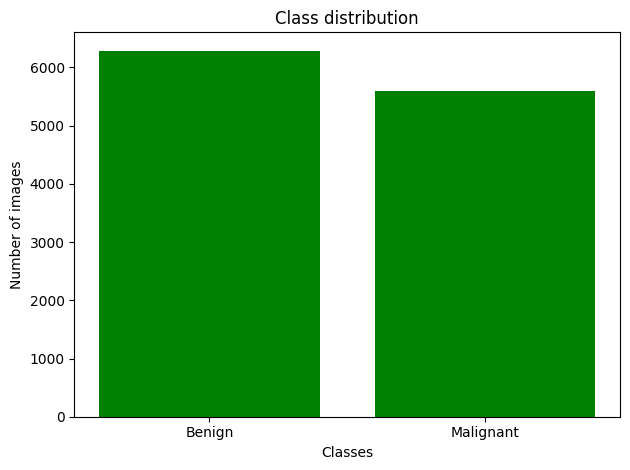

In [5]:
# Defines a function to plot the distribution of data classes
def plot_distribution(class_counts):
    # Creates a bar plot with class labels on the x-axis and the number of images on the y axis
    plt.bar(class_counts.keys(), class_counts.values(), color='green')
    # Labels the x-axis as 'Classes'
    plt.xlabel('Classes')
    # Labels the y-axis
    plt.ylabel('Number of images')
    # Title
    plt.title('Class distribution')
    # Adjusts the layout to ensure everything fits without overlapping
    plt.tight_layout()
    # Displays the plot
    plt.show()
    
plot_distribution(class_counts)

In [6]:
# Defines a function to visualise classes by selecting the first five items from each class
def visualize_classes(data):
    # Initialises an empty dictionary to store paths for the first five items of each class
    dict_for_five_item_in_each_class = {}
    
    # Iterate over each class label in the dataset directory
    for class_label in os.listdir(data):
        # Contructs the path tp the current class directory
        class_path = os.path.join(data, class_label)
        # Initialises a list to store the paths of the first five items in the current class
        items_paths = []
        
        # Enumerates over the item in the class directory
        for idx, item in enumerate(os.listdir(class_path)):
            # If the index is less than 5, adds the item path to the list
            if idx < 5:
                items_paths.append(os.path.join(class_path, item))
                
        # Stores the list of item paths in the dictionary with the class label as the key         
        dict_for_five_item_in_each_class[class_label] = items_paths
    
    # Returns the dictionary containing the paths for the first five items of each class
    return dict_for_five_item_in_each_class

# Calls the function to get the first five item paths for ecah class int he training dataset
dict_for_five_item_in_each_class = visualize_classes(os.path.join(DATA_PATH, 'train'))

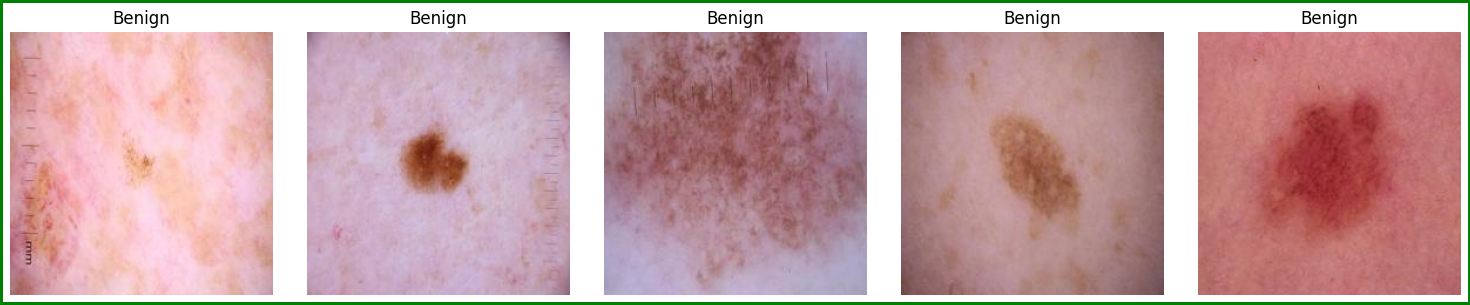

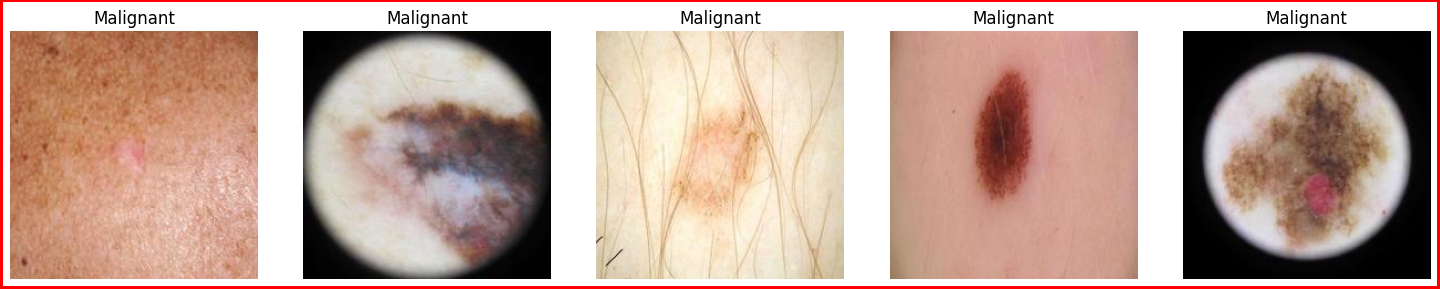

In [7]:
# Defines a function to plot 5 images from each class
def plot_5_images_from_each_class(dict_for_five_item_in_each_class):
    # Iterates over each class label and its corresponding image paths in the dictionary 
    for class_labels, image_paths in dict_for_five_item_in_each_class.items():
        # Creates a new figure for the current class with a specified size
        plt.figure(figsize=(15, 3))
        
        # Iterates over the image paths and their indices
        for i, image_path in enumerate(image_paths):
            # Opens the image using PIL
            img = PIL.Image.open(image_path)
            # Creates a subplot for each image
            plt.subplot(1, len(image_paths), i + 1)
            # Displays the image
            plt.imshow(img)
            # Sets the title of the sibplot to the class label
            plt.title(class_labels)
            # Removes the axis for a cleaner look
            plt.axis('off')
            
        # Add a border to the overall figure based on the class label
        fig = plt.gcf()  # Get the current figure
        if class_labels.lower() == 'benign':
            fig.patch.set_edgecolor('green')  # Set the edge color to green for benign
        elif class_labels.lower() == 'malignant':
            fig.patch.set_edgecolor('red')  # Set the edge color to red for malignant
        else:
            fig.patch.set_edgecolor('black')  # Default color for any other class - big problems if anything comes up!
        fig.patch.set_linewidth(4)  # Set the border width

        # Adjust the layout to ensure everything fits without overlapping
        plt.tight_layout()
        
    # Adjusts the layout to ensure everything fits without overlapping        
    plt.tight_layout()
    
    # Displays all the figures
    plt.show()


plot_5_images_from_each_class(dict_for_five_item_in_each_class)

# Splitting and Loading DataSets

In [8]:
# Define the path to the training images directory
trainpath = '/kaggle/input/train'#stored locally on kaggle

# Define the path to the testing images directory
testPath = '/kaggle/input/test'#stored locally on kaggle

# Load the traing datasets from above path and apply the transformations from above block
trainData = datasets.ImageFolder(root = trainpath, transform = transformer)
testData = datasets.ImageFolder(root = testPath, transform = valTransformer)

In [9]:
len(trainData) # Retrieves the total number of images in the trainData dataset, should be over 11k

11879

In [10]:
# Data loaders
batchSize = 16#32 #happy medium verified through testing

# Configure DataLoader for the training dataset
# Shuffling helps prevent the model from learning the order of data, enhancing generalisation
trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)

# Configure DataLoaders for validation and testing datasets
# No shuffling is needed as these loaders are used only for evaluating the model performance consistently

############# commented on 19th May 2024#####################
# valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)
testLoader = DataLoader(testData, batch_size = batchSize, shuffle = False, num_workers = 4)

# Setting Up Model

In [11]:
# Defining the early stopping class to monitor and stop training early
class EarlyStopping:
    def __init__(self, patience=5, 
                 min_delta=0,
                 restore_best_weights=True, path="best_model.pth"):
        # Initialise the early stopping mechanism
        self.patience = patience # Number of epochs to wait for improvement before stopping
        self.min_delta = min_delta # Minimum change in the monitored value to qualify as an improvement
        self.restore_best_weights = restore_best_weights # Whether to restore the model to the best state found
        self.best_model = None # Store the best model's state dictionary
        self.best_loss = None # Best validation loss observed
        self.counter = 0 # Counter to track epochs without improvement
        self.status = "" # Status message for logging
        self.path = path # Sets path to save the best model
        self.early_stop = False # Flag to indicate if early stopping is triggered

    def save_checkpoint(self, model):
        #Save the model's state dictionary
        torch.save(model.state_dict(), self.path)

    def __call__(self, model, val_loss,n,epoch):
        # Update the early stopping mechanism with the current validation loss
        self.save_checkpoint(model)
        
        # Check if early stopping should be triggered
        if self.best_loss is None:
            # If this is the first epoch, set the initial best loss and save the model
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            # If there is an improvement in validation loss
            self.best_model = copy.deepcopy(model.state_dict()) # Save the new best model
            # Update the best loss
            self.best_loss = val_loss
            # Reset the counter 
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            # If there is no improvement in validation loss
            self.counter += 1 # Increment the counter
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                # If the counter exceeds the patience threshold
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model) # Restore the previous best model
                    self.save_checkpoint(model) # Save teh restored best model
                self.early_stop = True # Set and early stopping flag
                return True # Indicate that early stopping has been triggered
        return False # Indicate that training should continue

# Training Step

In [12]:
# Defining the training step
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    # Set the model to training mode
    model.train()
    
    # Initilise cumulative loss and accuracy metrics
    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)
    
    # Process each batch using the dataloader
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        # Transfers input and labels to the appropriate device
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        # Forward pass through the model while removing extraneous dimensions from the output
        y_pred = model(X).squeeze()
        # Computes the loss between model predictions and true labels
        loss = loss_fn(y_pred, y)
        # Accumulates the loss values for later averaging
        train_loss += loss.detach().cpu().item()
        
        # Clears previous gradients before backwards pass
        optimizer.zero_grad()
        # Computes gradients of the loss with respect to model parameters
        loss.backward()
        # Adjusts model weights based on computed gradients
        optimizer.step()
        
        # Calculates probabilities from logits for accuracy measurements
        y_proba = torch.sigmoid(y_pred)
        # Updates accuracy metric with current batch's results
        accuracy_train.update(y_proba, y)
        
    #Calculates and returns the average loss and accuracy for the epoch    
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader) # Average loss across all batches
    
    return train_loss, train_accuracy

# Validation Step

In [13]:
def val_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    # Sets the model to evaluation mode
    model.eval()
    
    # Initialises the valdation loss accumulator
    val_loss = 0.
    # Initialises the accuracy metric for validation data, setting the threshold for binary classification
    accuracy_val = BinaryAccuracy(threshold = 0.5).to(device)
    
    # Iterates ove the validation data loader
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        # Transfers input and labels to the appropriate device
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        # Forward pass; compute the model's predictions for the batch
        y_pred = model(X).squeeze() # Squeeze removes dimensions of size 1 from the tensor
        #Computes the loss between the predictions and actual labels
        loss = loss_fn(y_pred, y)
        # Accumulates the loss over all batches
        val_loss += loss.detach().cpu().item()
        
        # Calculates the probabilities from the model's logits
        y_proba = torch.sigmoid(y_pred)
        #Updates the accuracy metric for the batch
        accuracy_val.update(y_proba, y)
    # Finalises the accuracy computation after processing all batches    
    val_accuracy = accuracy_val.compute()
    val_loss = val_loss/len(dataloader) # Average over all batches
    
    return val_loss, val_accuracy

# Training Loop

In [14]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimzier:torch.optim.Optimizer, 
          epochs:int,fold_num):
        # Initialises the lowest recorded validation loss to infinity for tracking the best model
    best_test_loss = float('inf')
    
    # Dictionary to store metrics across epochs
    results = {'train_loss':[], 
               'train_accuracy':[], 
               'val_loss':[], 
               'val_accuracy':[]}
    
    # Loops through each epoch, monitoring training and validation progress with a progress bar
    for epoch in tqdm(range(epochs)):
        # Performs a training step and captures trainign loss and accuracy
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        # Performs a validation step and captures validation loss and accuracy
        val_loss, val_accuracy = val_step(model = model, 
                                             dataloader = val_dataloader, 
                                             loss_fn = loss_fn)
        
        
        # Prints out epoch metrics to monitor progress
        print(f"Epoch: {epoch+1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"val Loss: {val_loss:.4f} | ", 
              f"val Accuracy: {val_accuracy:.4f}")
        
        # Checks if early stopping conditions are met
        early_stopping = EarlyStopping(patience = 5, min_delta = 0.0,path=f"best_model_fold{fold_num}.pth")
        early_stopping(model,val_loss,epoch+1,epochs)
    
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break # If they are it stops
        
        # Saves metrics to the results dictionary for later
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy.detach().cpu().item())
              
    return results   # Returns the collected metrics for all completed epochs

# K-Fold Cross Validation

In [15]:
# Will train for 30 epochs
EPOCHS = 30 # Limited by processing power

# Sets a seed for reproducibility of results
SEED = 42
torch.manual_seed(SEED) # Seed the random number generator for the CPU
torch.cuda.manual_seed(SEED) # Seed the random number generator for CUDA
    
    
# Sets the number of folds for K-Fold Cross Validation
num_folds = 5 # Cannot go much higher than this without paying for processing power
# Initialises KFold with the specified number of splits, shuffling, and a random seed for reducibility
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Dictionary to store results for each fold
MODEL_RESULTS = {}

# Iterates through each fold generated by KFolding
for fold, (train_index, val_index) in enumerate(kf.split(trainLoader.dataset)):
    #Prints the fold number for tracking while running
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    # Obtains the training and validation data for the current fold
    train_data_fold = torch.utils.data.Subset(trainLoader.dataset, train_index)
    val_data_fold = torch.utils.data.Subset(trainLoader.dataset, val_index)

    # Creates data loaders for the current fold
    train_loader_fold = DataLoader(train_data_fold, batch_size=batchSize, shuffle=True, num_workers = 4)
    val_loader_fold = DataLoader(val_data_fold, batch_size=batchSize, shuffle=False, num_workers = 4)
    
    ############ Model Initialisation ####################
    # Initialise the EfficientNet B7 Model with pre-trained weights
    model = models.efficientnet_b7(weights = 'DEFAULT')
    # Modifies the classifier layer to output a single value - for binary classification
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    
    # Moves to CPU if available
    if torch.cuda.is_available():
        model.cuda()
    
    # Defines the loss function and optimise
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    
    # Trains the model for ht ecurrent fold and stores the results
    MODEL_RESULTS[fold] = train(model, train_loader_fold, val_loader_fold, criterion, optimizer, EPOCHS,fold_num=fold)

==================== Fold 0 ====================


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:15<00:00, 17.0MB/s]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3617 |  Train Accuracy: 0.8456 |  val Loss: 0.3536 |  val Accuracy: 0.8359


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2906 |  Train Accuracy: 0.8816 |  val Loss: 0.2712 |  val Accuracy: 0.8859


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2663 |  Train Accuracy: 0.8931 |  val Loss: 0.3075 |  val Accuracy: 0.8535


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2524 |  Train Accuracy: 0.8954 |  val Loss: 0.3019 |  val Accuracy: 0.8935


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2436 |  Train Accuracy: 0.8975 |  val Loss: 0.2743 |  val Accuracy: 0.8809


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2303 |  Train Accuracy: 0.9077 |  val Loss: 0.2613 |  val Accuracy: 0.8956


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2174 |  Train Accuracy: 0.9150 |  val Loss: 0.3668 |  val Accuracy: 0.8527


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2081 |  Train Accuracy: 0.9182 |  val Loss: 0.2619 |  val Accuracy: 0.8944


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2046 |  Train Accuracy: 0.9173 |  val Loss: 0.2441 |  val Accuracy: 0.8986


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.1943 |  Train Accuracy: 0.9220 |  val Loss: 0.2353 |  val Accuracy: 0.9082


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.1892 |  Train Accuracy: 0.9244 |  val Loss: 0.2564 |  val Accuracy: 0.8893


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.1809 |  Train Accuracy: 0.9294 |  val Loss: 0.2945 |  val Accuracy: 0.8897


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1803 |  Train Accuracy: 0.9267 |  val Loss: 0.2419 |  val Accuracy: 0.9087


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1664 |  Train Accuracy: 0.9348 |  val Loss: 0.2741 |  val Accuracy: 0.8948


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1618 |  Train Accuracy: 0.9367 |  val Loss: 0.2401 |  val Accuracy: 0.9003


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1544 |  Train Accuracy: 0.9398 |  val Loss: 0.2401 |  val Accuracy: 0.9074


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1536 |  Train Accuracy: 0.9393 |  val Loss: 0.2776 |  val Accuracy: 0.9011


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1441 |  Train Accuracy: 0.9429 |  val Loss: 0.3030 |  val Accuracy: 0.8990


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1444 |  Train Accuracy: 0.9444 |  val Loss: 0.2683 |  val Accuracy: 0.8931


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1346 |  Train Accuracy: 0.9479 |  val Loss: 0.2593 |  val Accuracy: 0.8956


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1304 |  Train Accuracy: 0.9470 |  val Loss: 0.2888 |  val Accuracy: 0.9053


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1268 |  Train Accuracy: 0.9514 |  val Loss: 0.2568 |  val Accuracy: 0.9099


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1230 |  Train Accuracy: 0.9530 |  val Loss: 0.3143 |  val Accuracy: 0.9015


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1222 |  Train Accuracy: 0.9523 |  val Loss: 0.2765 |  val Accuracy: 0.8981


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1096 |  Train Accuracy: 0.9577 |  val Loss: 0.2594 |  val Accuracy: 0.9066


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1034 |  Train Accuracy: 0.9609 |  val Loss: 0.2614 |  val Accuracy: 0.9112


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1109 |  Train Accuracy: 0.9579 |  val Loss: 0.3115 |  val Accuracy: 0.8885


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.1054 |  Train Accuracy: 0.9610 |  val Loss: 0.2700 |  val Accuracy: 0.8990


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 29 |  Train Loss: 0.0876 |  Train Accuracy: 0.9663 |  val Loss: 0.3210 |  val Accuracy: 0.9045


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 30 |  Train Loss: 0.0962 |  Train Accuracy: 0.9637 |  val Loss: 0.2684 |  val Accuracy: 0.9104
==================== Fold 1 ====================


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3651 |  Train Accuracy: 0.8469 |  val Loss: 0.3455 |  val Accuracy: 0.8708


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2916 |  Train Accuracy: 0.8779 |  val Loss: 0.3065 |  val Accuracy: 0.8948


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2729 |  Train Accuracy: 0.8867 |  val Loss: 0.2235 |  val Accuracy: 0.9024


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2583 |  Train Accuracy: 0.8938 |  val Loss: 0.2347 |  val Accuracy: 0.9040


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2421 |  Train Accuracy: 0.8993 |  val Loss: 0.2446 |  val Accuracy: 0.9133


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2342 |  Train Accuracy: 0.9036 |  val Loss: 0.2053 |  val Accuracy: 0.9104


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2225 |  Train Accuracy: 0.9083 |  val Loss: 0.2637 |  val Accuracy: 0.8939


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2170 |  Train Accuracy: 0.9110 |  val Loss: 0.2189 |  val Accuracy: 0.9061


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2119 |  Train Accuracy: 0.9109 |  val Loss: 0.2301 |  val Accuracy: 0.9061


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2036 |  Train Accuracy: 0.9169 |  val Loss: 0.2214 |  val Accuracy: 0.9074


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.2263 |  Train Accuracy: 0.9054 |  val Loss: 0.2220 |  val Accuracy: 0.9057


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.2087 |  Train Accuracy: 0.9154 |  val Loss: 0.2108 |  val Accuracy: 0.9171


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1901 |  Train Accuracy: 0.9251 |  val Loss: 0.2010 |  val Accuracy: 0.9209


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1774 |  Train Accuracy: 0.9272 |  val Loss: 0.2277 |  val Accuracy: 0.9049


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1724 |  Train Accuracy: 0.9284 |  val Loss: 0.2343 |  val Accuracy: 0.9078


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1639 |  Train Accuracy: 0.9314 |  val Loss: 0.2092 |  val Accuracy: 0.9129


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1717 |  Train Accuracy: 0.9314 |  val Loss: 0.2360 |  val Accuracy: 0.8981


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1601 |  Train Accuracy: 0.9367 |  val Loss: 0.2105 |  val Accuracy: 0.9154


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1479 |  Train Accuracy: 0.9401 |  val Loss: 0.2369 |  val Accuracy: 0.9108


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1461 |  Train Accuracy: 0.9422 |  val Loss: 0.2027 |  val Accuracy: 0.9221


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1368 |  Train Accuracy: 0.9452 |  val Loss: 0.2349 |  val Accuracy: 0.9129


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1329 |  Train Accuracy: 0.9471 |  val Loss: 0.1914 |  val Accuracy: 0.9205


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1333 |  Train Accuracy: 0.9479 |  val Loss: 0.1994 |  val Accuracy: 0.9251


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1232 |  Train Accuracy: 0.9529 |  val Loss: 0.2523 |  val Accuracy: 0.9095


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1172 |  Train Accuracy: 0.9531 |  val Loss: 0.2216 |  val Accuracy: 0.9125


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1148 |  Train Accuracy: 0.9556 |  val Loss: 0.2160 |  val Accuracy: 0.9280


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1097 |  Train Accuracy: 0.9571 |  val Loss: 0.2281 |  val Accuracy: 0.9196


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.1044 |  Train Accuracy: 0.9585 |  val Loss: 0.2427 |  val Accuracy: 0.9133


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 29 |  Train Loss: 0.0990 |  Train Accuracy: 0.9623 |  val Loss: 0.2356 |  val Accuracy: 0.9200


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 30 |  Train Loss: 0.0990 |  Train Accuracy: 0.9625 |  val Loss: 0.2310 |  val Accuracy: 0.9251
==================== Fold 2 ====================


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3653 |  Train Accuracy: 0.8445 |  val Loss: 0.3471 |  val Accuracy: 0.8699


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2981 |  Train Accuracy: 0.8737 |  val Loss: 0.2480 |  val Accuracy: 0.8893


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2765 |  Train Accuracy: 0.8837 |  val Loss: 0.2443 |  val Accuracy: 0.8960


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2567 |  Train Accuracy: 0.8938 |  val Loss: 0.2469 |  val Accuracy: 0.8986


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2455 |  Train Accuracy: 0.8995 |  val Loss: 0.2349 |  val Accuracy: 0.9028


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2332 |  Train Accuracy: 0.9028 |  val Loss: 0.2304 |  val Accuracy: 0.9040


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2200 |  Train Accuracy: 0.9096 |  val Loss: 0.2191 |  val Accuracy: 0.9175


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2207 |  Train Accuracy: 0.9101 |  val Loss: 0.2213 |  val Accuracy: 0.9040


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2153 |  Train Accuracy: 0.9163 |  val Loss: 0.2251 |  val Accuracy: 0.9095


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2001 |  Train Accuracy: 0.9192 |  val Loss: 0.2116 |  val Accuracy: 0.9078


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.1927 |  Train Accuracy: 0.9233 |  val Loss: 0.2010 |  val Accuracy: 0.9196


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.1826 |  Train Accuracy: 0.9233 |  val Loss: 0.1966 |  val Accuracy: 0.9259


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1778 |  Train Accuracy: 0.9280 |  val Loss: 0.2436 |  val Accuracy: 0.9125


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1777 |  Train Accuracy: 0.9270 |  val Loss: 0.2077 |  val Accuracy: 0.9175


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1614 |  Train Accuracy: 0.9350 |  val Loss: 0.2074 |  val Accuracy: 0.9205


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1546 |  Train Accuracy: 0.9405 |  val Loss: 0.2529 |  val Accuracy: 0.9120


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1557 |  Train Accuracy: 0.9388 |  val Loss: 0.1965 |  val Accuracy: 0.9192


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1422 |  Train Accuracy: 0.9436 |  val Loss: 0.2004 |  val Accuracy: 0.9213


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1428 |  Train Accuracy: 0.9439 |  val Loss: 0.2233 |  val Accuracy: 0.9112


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1407 |  Train Accuracy: 0.9438 |  val Loss: 0.2134 |  val Accuracy: 0.9217


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1316 |  Train Accuracy: 0.9505 |  val Loss: 0.2134 |  val Accuracy: 0.9234


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1294 |  Train Accuracy: 0.9518 |  val Loss: 0.2063 |  val Accuracy: 0.9221


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1203 |  Train Accuracy: 0.9545 |  val Loss: 0.2297 |  val Accuracy: 0.9150


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1203 |  Train Accuracy: 0.9543 |  val Loss: 0.2008 |  val Accuracy: 0.9310


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1167 |  Train Accuracy: 0.9544 |  val Loss: 0.2183 |  val Accuracy: 0.9196


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1057 |  Train Accuracy: 0.9591 |  val Loss: 0.2349 |  val Accuracy: 0.9209


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1027 |  Train Accuracy: 0.9595 |  val Loss: 0.2480 |  val Accuracy: 0.9221


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.1010 |  Train Accuracy: 0.9607 |  val Loss: 0.2470 |  val Accuracy: 0.9213


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 29 |  Train Loss: 0.1000 |  Train Accuracy: 0.9618 |  val Loss: 0.2434 |  val Accuracy: 0.9137


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 30 |  Train Loss: 0.0901 |  Train Accuracy: 0.9657 |  val Loss: 0.2662 |  val Accuracy: 0.9230
==================== Fold 3 ====================


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3636 |  Train Accuracy: 0.8439 |  val Loss: 7.1639 |  val Accuracy: 0.7858


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.3075 |  Train Accuracy: 0.8697 |  val Loss: 0.3088 |  val Accuracy: 0.8796


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2771 |  Train Accuracy: 0.8837 |  val Loss: 0.9432 |  val Accuracy: 0.8952


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2582 |  Train Accuracy: 0.8930 |  val Loss: 0.3436 |  val Accuracy: 0.8561


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2797 |  Train Accuracy: 0.8825 |  val Loss: 0.3192 |  val Accuracy: 0.8632


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2536 |  Train Accuracy: 0.8950 |  val Loss: 0.2863 |  val Accuracy: 0.8792


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2443 |  Train Accuracy: 0.8970 |  val Loss: 0.5637 |  val Accuracy: 0.8927


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2281 |  Train Accuracy: 0.9063 |  val Loss: 0.2447 |  val Accuracy: 0.8986


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2216 |  Train Accuracy: 0.9087 |  val Loss: 0.2216 |  val Accuracy: 0.9120


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2129 |  Train Accuracy: 0.9119 |  val Loss: 0.2367 |  val Accuracy: 0.9066


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.2104 |  Train Accuracy: 0.9168 |  val Loss: 0.2017 |  val Accuracy: 0.9184


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.2069 |  Train Accuracy: 0.9199 |  val Loss: 0.4851 |  val Accuracy: 0.8460


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1938 |  Train Accuracy: 0.9218 |  val Loss: 0.2196 |  val Accuracy: 0.9141


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1828 |  Train Accuracy: 0.9273 |  val Loss: 0.2121 |  val Accuracy: 0.9146


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1781 |  Train Accuracy: 0.9282 |  val Loss: 0.2165 |  val Accuracy: 0.9158


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1812 |  Train Accuracy: 0.9282 |  val Loss: 0.1972 |  val Accuracy: 0.9188


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1650 |  Train Accuracy: 0.9328 |  val Loss: 0.2374 |  val Accuracy: 0.8960


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1617 |  Train Accuracy: 0.9335 |  val Loss: 0.2477 |  val Accuracy: 0.9154


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1527 |  Train Accuracy: 0.9377 |  val Loss: 0.2277 |  val Accuracy: 0.9087


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1507 |  Train Accuracy: 0.9409 |  val Loss: 0.2080 |  val Accuracy: 0.9158


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1415 |  Train Accuracy: 0.9440 |  val Loss: 0.2186 |  val Accuracy: 0.9167


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1385 |  Train Accuracy: 0.9433 |  val Loss: 0.2465 |  val Accuracy: 0.9024


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1279 |  Train Accuracy: 0.9493 |  val Loss: 0.2660 |  val Accuracy: 0.9091


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1278 |  Train Accuracy: 0.9479 |  val Loss: 0.2936 |  val Accuracy: 0.9116


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1202 |  Train Accuracy: 0.9518 |  val Loss: 0.2800 |  val Accuracy: 0.9120


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1162 |  Train Accuracy: 0.9520 |  val Loss: 0.2516 |  val Accuracy: 0.9019


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1157 |  Train Accuracy: 0.9555 |  val Loss: 0.2276 |  val Accuracy: 0.9120


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.1080 |  Train Accuracy: 0.9578 |  val Loss: 0.2364 |  val Accuracy: 0.9162


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 29 |  Train Loss: 0.1079 |  Train Accuracy: 0.9583 |  val Loss: 0.2480 |  val Accuracy: 0.9205


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 30 |  Train Loss: 0.0994 |  Train Accuracy: 0.9607 |  val Loss: 0.2755 |  val Accuracy: 0.9188
==================== Fold 4 ====================


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3648 |  Train Accuracy: 0.8399 |  val Loss: 0.8557 |  val Accuracy: 0.7924


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2981 |  Train Accuracy: 0.8735 |  val Loss: 0.3484 |  val Accuracy: 0.8716


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2713 |  Train Accuracy: 0.8871 |  val Loss: 0.2492 |  val Accuracy: 0.8947


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2522 |  Train Accuracy: 0.8955 |  val Loss: 0.2733 |  val Accuracy: 0.8935


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2456 |  Train Accuracy: 0.9018 |  val Loss: 0.3459 |  val Accuracy: 0.8771


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2346 |  Train Accuracy: 0.9045 |  val Loss: 0.2200 |  val Accuracy: 0.9036


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2222 |  Train Accuracy: 0.9106 |  val Loss: 0.2318 |  val Accuracy: 0.9019


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2182 |  Train Accuracy: 0.9115 |  val Loss: 0.2406 |  val Accuracy: 0.9061


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2051 |  Train Accuracy: 0.9173 |  val Loss: 0.2222 |  val Accuracy: 0.9095


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.1989 |  Train Accuracy: 0.9188 |  val Loss: 0.2940 |  val Accuracy: 0.8947


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.1951 |  Train Accuracy: 0.9210 |  val Loss: 0.4675 |  val Accuracy: 0.8817


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.1967 |  Train Accuracy: 0.9237 |  val Loss: 0.2303 |  val Accuracy: 0.9074


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1804 |  Train Accuracy: 0.9283 |  val Loss: 0.2130 |  val Accuracy: 0.9124


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1699 |  Train Accuracy: 0.9326 |  val Loss: 0.2169 |  val Accuracy: 0.9208


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1632 |  Train Accuracy: 0.9338 |  val Loss: 0.2212 |  val Accuracy: 0.9124


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1592 |  Train Accuracy: 0.9367 |  val Loss: 0.2095 |  val Accuracy: 0.9141


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1557 |  Train Accuracy: 0.9382 |  val Loss: 0.2374 |  val Accuracy: 0.9078


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1445 |  Train Accuracy: 0.9424 |  val Loss: 0.2128 |  val Accuracy: 0.9229


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1415 |  Train Accuracy: 0.9435 |  val Loss: 0.2263 |  val Accuracy: 0.9149


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1403 |  Train Accuracy: 0.9442 |  val Loss: 0.2440 |  val Accuracy: 0.9175


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1364 |  Train Accuracy: 0.9488 |  val Loss: 0.2064 |  val Accuracy: 0.9179


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1185 |  Train Accuracy: 0.9541 |  val Loss: 0.2451 |  val Accuracy: 0.9065


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1180 |  Train Accuracy: 0.9511 |  val Loss: 0.2043 |  val Accuracy: 0.9221


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1147 |  Train Accuracy: 0.9554 |  val Loss: 0.2406 |  val Accuracy: 0.9154


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1112 |  Train Accuracy: 0.9558 |  val Loss: 0.2131 |  val Accuracy: 0.9145


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1057 |  Train Accuracy: 0.9593 |  val Loss: 0.2286 |  val Accuracy: 0.9171


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1055 |  Train Accuracy: 0.9599 |  val Loss: 0.2277 |  val Accuracy: 0.9149


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.1000 |  Train Accuracy: 0.9635 |  val Loss: 0.2405 |  val Accuracy: 0.9200


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 29 |  Train Loss: 0.0970 |  Train Accuracy: 0.9644 |  val Loss: 0.2882 |  val Accuracy: 0.9040


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 30 |  Train Loss: 0.0966 |  Train Accuracy: 0.9632 |  val Loss: 0.2611 |  val Accuracy: 0.9238


# Assessing Results

In [16]:
# Lists all the saved model files - should equal the number of folds
SavedModels = [os.path.join("/kaggle/working",i) for i in os.listdir('/kaggle/working') if i.endswith('.pth')]
SavedModels

['/kaggle/working/best_model_fold2.pth',
 '/kaggle/working/best_model_fold1.pth',
 '/kaggle/working/best_model_fold0.pth',
 '/kaggle/working/best_model_fold3.pth',
 '/kaggle/working/best_model_fold4.pth']

In [17]:
# Sorts that same list
SavedModels = sorted(SavedModels,key=lambda x:x.split('.')[0][-1])
SavedModels

['/kaggle/working/best_model_fold0.pth',
 '/kaggle/working/best_model_fold1.pth',
 '/kaggle/working/best_model_fold2.pth',
 '/kaggle/working/best_model_fold3.pth',
 '/kaggle/working/best_model_fold4.pth']

===============Fold-0 Model-> /kaggle/working/best_model_fold0.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1000
         1.0       0.94      0.94      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy 0.942


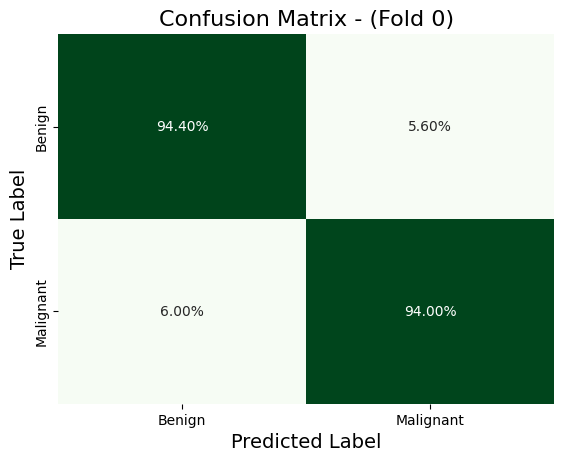

===============Fold-1 Model-> /kaggle/working/best_model_fold1.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1000
         1.0       0.93      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy 0.9395


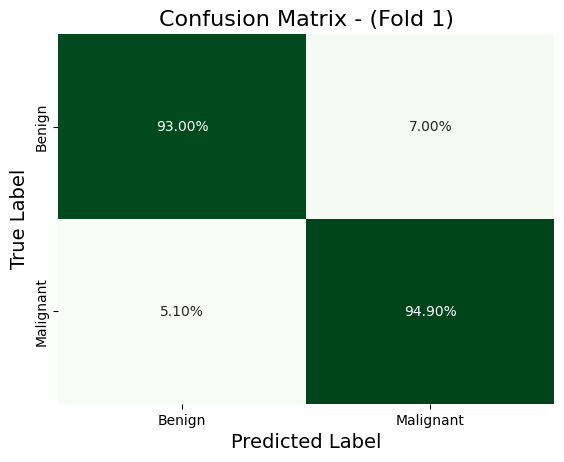

===============Fold-2 Model-> /kaggle/working/best_model_fold2.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1000
         1.0       0.95      0.93      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy 0.9385


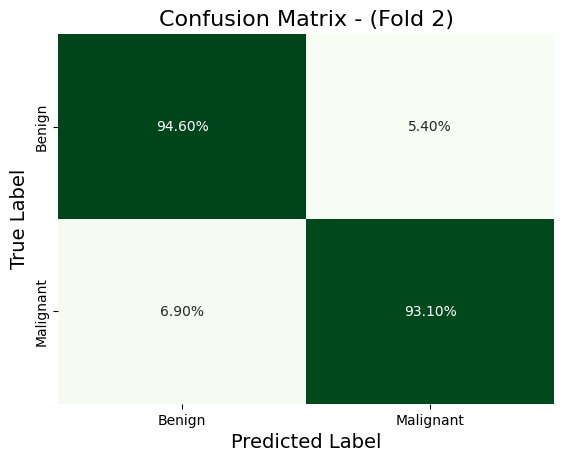

===============Fold-3 Model-> /kaggle/working/best_model_fold3.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.88      0.96      0.91      1000
         1.0       0.95      0.86      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Accuracy 0.9105


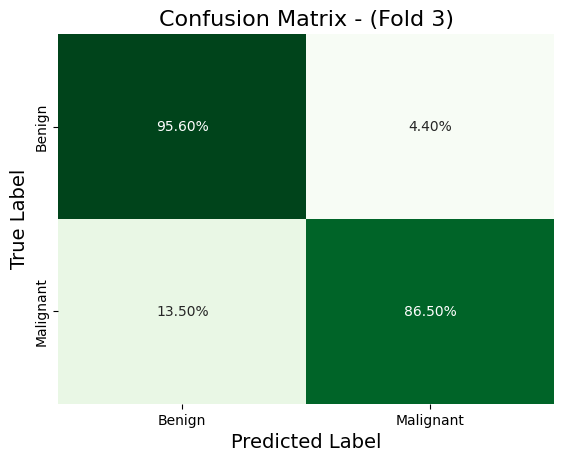

===============Fold-4 Model-> /kaggle/working/best_model_fold4.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1000
         1.0       0.94      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy 0.9425


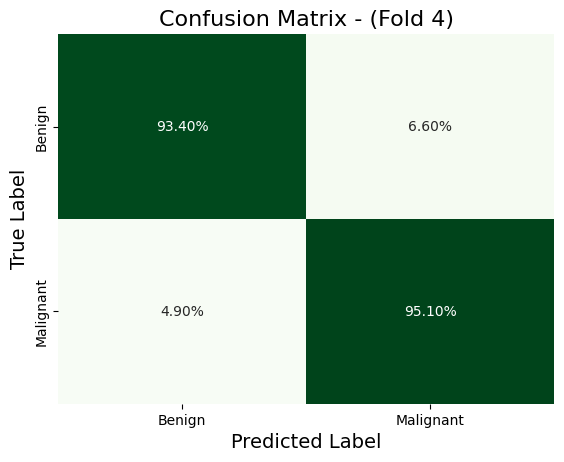

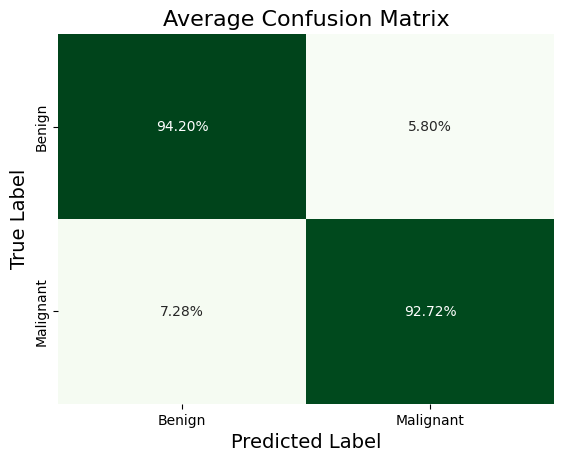

In [18]:
# Initialises the EfficientNet B7 model with pre-trained weights
model1 = models.efficientnet_b7(weights='DEFAULT')
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 1)

# Initialises a list to accumulate confusion matrices
confusion_matrices = []

# Iterates over each saved model from the different folds
for fold_id, saved_model in enumerate(SavedModels):
    print(f'===============Fold-{fold_id} Model-> {saved_model}==================')
    
    # Loads the saved model state dictionary
    model1.load_state_dict(torch.load(saved_model)) # map_location=torch.device('cuda') 

    # Switches the model to evaluation mode
    model1.eval()
    # Moves the model to the configured device (CPU or GPU)
    model1 = model1.to(device)
    
    # Initialises lists to store labels and predictions
    allLabels = []
    allPreds = []

    # Disables gradient calculations for performance optimization
    with torch.no_grad():
        # Iterates over batches of data in the test dataset
        for inputs, labels in testLoader:
            # Moves the inputs and labels to the configured device
            inputs, labels = inputs.to(device), labels.to(device)
            # Ensures labels are the correct shape and type for calculation
            labels = labels.unsqueeze(1).float()

            # Generates model outputs for the current batch
            outputs = model1(inputs)
            # Applies a sigmoid activation to convert logits to probabilities and threshold at 0.5 to obtain binary predictions
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            # Stores the labels and predictions, converting them to numpy arrays
            allLabels.extend(labels.cpu().numpy())
            allPreds.extend(predictions.cpu().numpy())

    # Converts lists of labels and predictions into numpy arrays for scikit-learn
    allLabels = np.array(allLabels)
    allPreds = np.array(allPreds)

    # Prints classification metrics to evaluate the model
    print('Classification report', classification_report(allLabels, allPreds))
    print('Accuracy', accuracy_score(allLabels, allPreds))

    # Calculates and store the confusion matrix
    matrix = confusion_matrix(allLabels, allPreds)
    confusion_matrices.append(matrix)

    # Normalises the confusion matrix
    cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plots the formatted normalised confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', xticklabels=testData.classes, yticklabels=testData.classes, cbar=False)
    plt.title(f'Confusion Matrix - (Fold {fold_id})', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()

# Computes the average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Normalises the average confusion matrix
avg_cm_normalized = avg_confusion_matrix.astype('float') / avg_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plots and formats the normalized average confusion matrix
sns.heatmap(avg_cm_normalized, annot=True, fmt='.2%', cmap='Greens', xticklabels=testData.classes, yticklabels=testData.classes, cbar=False)
plt.title('Average Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


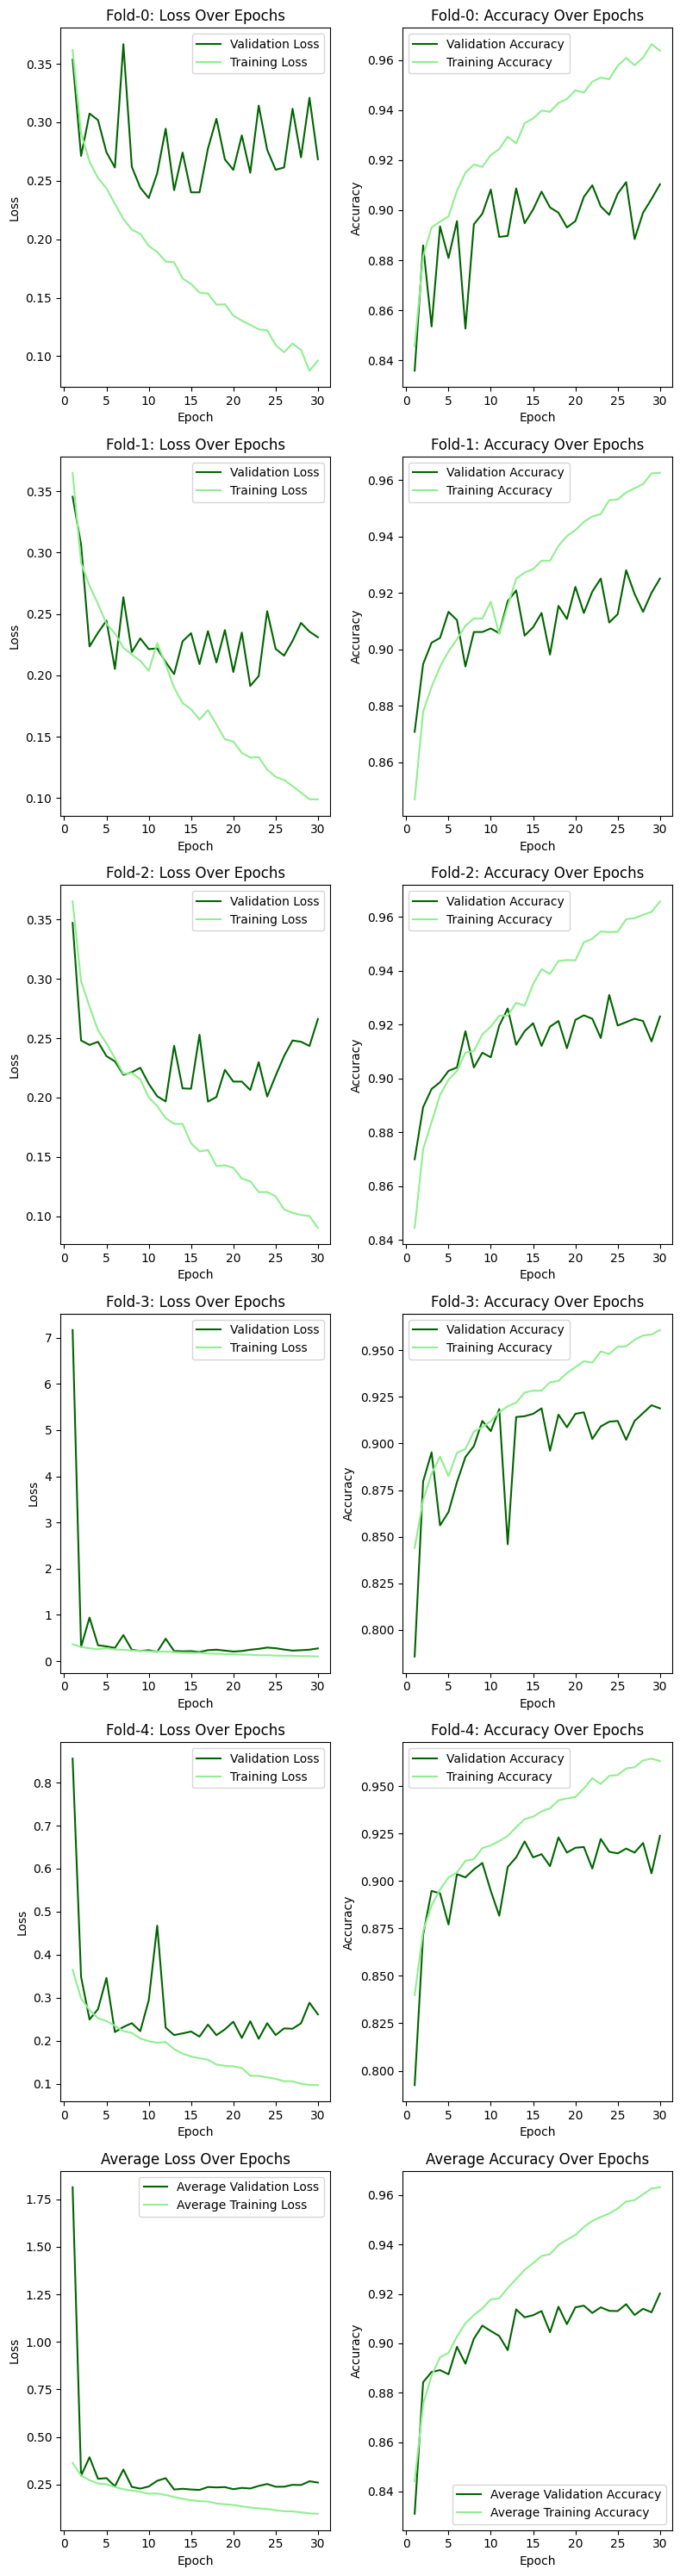

In [19]:
# Number of models in MODEL_RESULTS
num_models = 5

# Initialize lists to accumulate validation loss and accuracy for averaging
avg_val_loss = np.zeros_like(MODEL_RESULTS[0]['val_loss'])
avg_val_accuracy = np.zeros_like(MODEL_RESULTS[0]['val_accuracy'])
avg_train_loss = np.zeros_like(MODEL_RESULTS[0]['train_loss'])
avg_train_accuracy = np.zeros_like(MODEL_RESULTS[0]['train_accuracy'])

# Create a figure with a specified size
plt.figure(figsize=(8, 5 * (num_models + 1)))  # +1 to accommodate the average plot

# Iterate through each model's results
for i in range(num_models):
    model_name = i  # Model index
    val_loss = MODEL_RESULTS[model_name]['val_loss']  # Validation loss for the current model
    val_accuracy = MODEL_RESULTS[model_name]['val_accuracy']  # Validation accuracy for the current model
    
    train_loss = MODEL_RESULTS[model_name]['train_loss']  # Training loss for the current model
    train_accuracy = MODEL_RESULTS[model_name]['train_accuracy']  # Training accuracy for the current model
    
    epochs = range(1, len(val_loss) + 1)  # Epoch numbers

    # Accumulate the validation loss and accuracy for averaging
    avg_val_loss += np.array(val_loss)
    avg_val_accuracy += np.array(val_accuracy)
    avg_train_loss += np.array(train_loss)
    avg_train_accuracy += np.array(train_accuracy)

    # Subplot for validation and training loss
    plt.subplot(num_models + 1, 2, 2 * i + 1)  # num_models rows + 1 for average, 2 columns, current subplot for loss
    plt.plot(epochs, val_loss, label='Validation Loss', color='darkgreen')  # Plot validation loss in dark green
    plt.plot(epochs, train_loss, label='Training Loss', color='lightgreen')  # Plot training loss in light green
    plt.title(f'Fold-{model_name}: Loss Over Epochs')  # Title for the subplot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Loss')  # Y-axis label
    plt.legend()  # Display legend

    # Subplot for validation and training accuracy
    plt.subplot(num_models + 1, 2, 2 * i + 2)  # num_models rows + 1 for average, 2 columns, current subplot for accuracy
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='darkgreen')  # Plot validation accuracy in dark green
    plt.plot(epochs, train_accuracy, label='Training Accuracy', color='lightgreen')  # Plot training accuracy in light green
    plt.title(f'Fold-{model_name}: Accuracy Over Epochs')  # Title for the subplot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Accuracy')  # Y-axis label
    plt.legend()  # Display legend

# Compute the average validation loss and accuracy across all folds
avg_val_loss /= num_models
avg_val_accuracy /= num_models
avg_train_loss /= num_models
avg_train_accuracy /= num_models

# Plot the average validation and training loss
plt.subplot(num_models + 1, 2, 2 * num_models + 1)  # Position for the average loss plot
plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='darkgreen')  # Plot average validation loss in dark green
plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='lightgreen')  # Plot average training loss in light green
plt.title('Average Loss Over Epochs')  # Title for the average plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display legend

# Plot the average validation and training accuracy
plt.subplot(num_models + 1, 2, 2 * num_models + 2)  # Position for the average accuracy plot
plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy', color='darkgreen')  # Plot average validation accuracy in dark green
plt.plot(epochs, avg_train_accuracy, label='Average Training Accuracy', color='lightgreen')  # Plot average training accuracy in light green
plt.title('Average Accuracy Over Epochs')  # Title for the average plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display legend

# Adjust the layout to prevent overlap
plt.tight_layout()
# Display the plots
plt.show()


# Prediction Example

In [20]:
# Initialises the EfficientNet B7 model with pre-trained weights
model1 = models.efficientnet_b7(weights = 'DEFAULT')

# Modifies the classifier layer to output a single value - binary classification
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 1)

# Loads the model state dictionary from a saved file
# The map_location parameter ensures compatibility with the current device
model1.load_state_dict(torch.load('/kaggle/working/best_model_fold4.pth',map_location=torch.device('cpu'))) 

# Defines the path to the image to be predicted - image 6299 is taken for example
image_path = "/kaggle/input/test/Benign/6299.jpg"

In [21]:
# Allows manual check the shape of the inputs being recieved
inputs.shape

torch.Size([16, 3, 170, 170])

In [22]:
# Validation transformer - image processing steps before being fed into the model
#Defines the validation transformer for preprocesssing images 
valTransformer = transforms.Compose([
    # Resizes the image to the specified dimensions without antialiasing
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True), # ImageDimensions is defined earlier
    # Centre crops the image to ensure it's centres and of the specified size
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),
    
    # Converts the image to a tensor
    transforms.ToTensor(),
    
    # Normalises the image with the mean and standard deviation used in pre-trained models
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [23]:
# Appleis the above validation transformer to the input image
image = Image.open(image_path).convert("RGB") # Opens the file and converts it to RGB format
image = valTransformer(image) # Applies the transformer

# Reshape the image to add batch dimension - required for model input
image = image.unsqueeze(0) 

In [24]:
# Allows manual check to see that the image has been reshaped
image.shape 

torch.Size([1, 3, 170, 170])

In [25]:
target = ['Benign','Malignant']
with torch.no_grad():
    # Sets the model to evaluation mode
    model1.eval()
    # Ensures the image tensor is on the CPU
    inputs = image.to('cpu')
    # Generates model outputs for the input image
    outputs = model1(inputs)
    # Applies a sigmoud activation to convert logits to probabilities
    predictions = (torch.sigmoid(outputs) > 0.5).float()
    # Prints the predicted class label - benign or malignant: Example Image 6299 is malignant
    print(target[int(predictions.item())])

Benign
